# Computer Vision: Plants Classification Other models

This classification is based on the **Plant Seedlings Dataset**, which contains images of approximately 960 unique plants belonging to 12 species at several growth stages, with a resolution of about 10 pixels per mm of annotated RGB images.

The dataset includes the following species:


|English     |Latin               |EPPO|
|:-----------|:-------------------|:---|
|Maize       |Zea mays L.         |ZEAMX|
|Common wheat|Triticum aestivum L.|TRZAX|
|Sugar beet|Beta vulgaris var. altissima|BEAVA|
|Scentless Mayweed|Matricaria perforata Mérat|MATIN|
|Common Chickweed|Stellaria media|STEME|
|Shepherd’s Purse|Capsella bursa-pastoris|CAPBP|
|Cleavers|Galium aparine L.|GALAP|
|Charlock|Sinapis arvensis L.|SINAR|
|Fat Hen|Chenopodium album L.|CHEAL|
|Small-flowered Cranesbill|Geranium pusillum|GERSS|
|Black-grass|Alopecurus myosuroides|ALOMY|
|Loose Silky-bent|Apera spica-venti|APESV|

In [1]:
%matplotlib inline
%load_ext watermark
%watermark -v -m -p numpy,pandas,sklearn,tensorflow -g

import re
import os
import sys
from time import time
import pickle
import pathlib
import itertools
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import watermark

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

np.random.seed(42)

CPython 3.7.3
IPython 7.8.0

numpy 1.17.3
pandas 0.25.1
sklearn 0.21.3
tensorflow 2.0.0

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.0.0
machine    : x86_64
processor  : i386
CPU cores  : 16
interpreter: 64bit
Git hash   : cce2461b01b9fcdf75685025c539c1b8bb409d19


In [2]:
# Libraries specific of Deep learning and images
import imageio
from skimage.transform import resize as imresize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf2
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.layers import Input, Activation, Maximum, ZeroPadding2D, concatenate, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint

## 1. Loading data

### 1.1 Using previous notebook dataset

In [3]:
PLANT_CLASSES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 
                 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 
                 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
CLASSES_DICT_NAMES = {name: k for k, name in zip(range(len(PLANT_CLASSES)), PLANT_CLASSES)}
CLASSES_DICT_NUM = {k: name for k, name in zip(range(len(PLANT_CLASSES)), PLANT_CLASSES)}
NUM_CATEGORIES = len(PLANT_CLASSES)

In [7]:
def get_abbreviation(name):
    split_regex = re.compile("[ \-,;:]")
    splitted = split_regex.split(name)
    if len(splitted) == 1:
        return splitted[0][:2].upper()
    else:
        return "".join([k[0].upper() for k in splitted])

ABBREVIATIONS = [get_abbreviation(m) for m in PLANT_CLASSES]
print(f"Abbreviations: {ABBREVIATIONS}")

RESHAPE_SIZE = (65, 65, 3)

Abbreviations: ['BG', 'CH', 'CL', 'CC', 'CW', 'FH', 'LSB', 'MA', 'SM', 'SP', 'SFC', 'SB']


In [5]:
%store -r dataset
X_tr, Y_tr, X_te, Y_te, X_val, Y_val = dataset

## 2. Model
### 2.1 Model definition



In [8]:
def conv_layer(feature_batch, feature_map, kernel_size=(3, 3),strides=(1,1), zp_flag=False):
    if zp_flag:
        zp = ZeroPadding2D((1,1))(feature_batch)
    else:
        zp = feature_batch
    conv = Conv2D(filters=feature_map, kernel_size=kernel_size, strides=strides)(zp)
    bn = BatchNormalization(axis=3)(conv)
    act = LeakyReLU(1/10)(bn)
    return act


def dense_set(inp_layer, n, activation, drop_rate=0.3):
    dp = Dropout(drop_rate)(inp_layer)
    dns = Dense(n)(dp)
    bn = BatchNormalization(axis=-1)(dns)
    act = Activation(activation=activation)(bn)
    return act


def multi_conv_model(img_shape=RESHAPE_SIZE, opt_name="Adam"):
    input_img = Input(shape=img_shape)

    # First stage of Conv and Max Pooling
    conv1 = conv_layer(input_img, 64)
    conv2 = conv_layer(conv1, 64, zp_flag=False)
    mp1 = MaxPool2D(pool_size=(3, 3), strides=(2, 2))(conv2)
    # Second stage of Conv and Max Pooling
    conv3 = conv_layer(mp1, 128)
    conv4 = conv_layer(conv3, 128)
    mp2 = MaxPool2D(pool_size=(3, 3), strides=(2, 2))(conv4)
    # Third stage
    conv7 = conv_layer(mp2, 256)
    conv8 = conv_layer(conv7, 256)
    conv9 = conv_layer(conv8, 256)
    mp3 = MaxPool2D(pool_size=(3, 3), strides=(2, 2))(conv9)
    # Apply dense layers
    flt = Flatten()(mp3)
    ds1 = dense_set(flt, 128, activation='tanh')
    out = dense_set(ds1, 12, activation='softmax')

    model = Model(inputs=input_img, outputs=out)
    
    # The first 50 epochs are used by Adam opt.
    # Then 30 epochs are used by SGD opt.
    if opt_name == "Adam":
        model_optimizer = Adam(lr=2 * 1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    elif opt_name == "SGD":
        model_optimizer = SGD(lr=1 * 1e-1, momentum=0.9, nesterov=True)
    else:
        raise ValueError("Selected optimizer not supported")
    model.compile(loss='categorical_crossentropy',
                   optimizer=model_optimizer,
                   metrics=['accuracy'])
    # Display the model's architecture
    model.summary()
    return model

In [9]:
ADAM_MODEL = "./models/CNN_model2_weights_Adam.hdf5"
SGD_MODEL = "./models/CNN_model2_weights_SGD.hdf5"

def get_callbacks(filepath, patience=5):
    # Reduce learning rate when a metric has stopped improving
    lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', 
                                  factor=0.1, 
                                  min_delta=1e-5, 
                                  patience=patience, 
                                  verbose=1)
    # Save the model after every epoch
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [lr_reduce, msave]


def train_model(X_tr, Y_tr, X_te, Y_te, batch_size=86, epochs=50, opt="Adam", weights_file=ADAM_MODEL):
    callbacks = get_callbacks(filepath=weights_file, patience=3)
    plant_model = multi_conv_model(opt_name=opt)
    if os.path.exists(weights_file):
        plant_model.load_weights(filepath=weights_file)
    
    gen = ImageDataGenerator(
        rotation_range=360.,
        width_shift_range=0.3,
        height_shift_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True)
    
    history = plant_model.fit_generator(
        gen.flow(X_tr, Y_tr, batch_size=batch_size),
        steps_per_epoch=10*len(X_tr)/batch_size,
        epochs=epochs,
        verbose=2,
        shuffle=True,
        validation_data=(X_te, Y_te),
        callbacks=callbacks)
    return history

In [ ]:
%%time
history_m2_1 = train_model(X_tr, Y_tr, X_te, Y_te, 
                           batch_size=86, 
                           epochs=30, 
                           opt="Adam", 
                           weights_file=ADAM_MODEL)

In [ ]:
# Training first 30 epochs with SGD and later on with Adam

history_m2_1 = train_model(X_tr, Y_tr, X_te, Y_te, 
                           batch_size=86, 
                           epochs=50, 
                           opt="SGD", 
                           weights_file=ADAM_MODEL)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 65, 65, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 63, 63, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 61, 61, 64)        0     

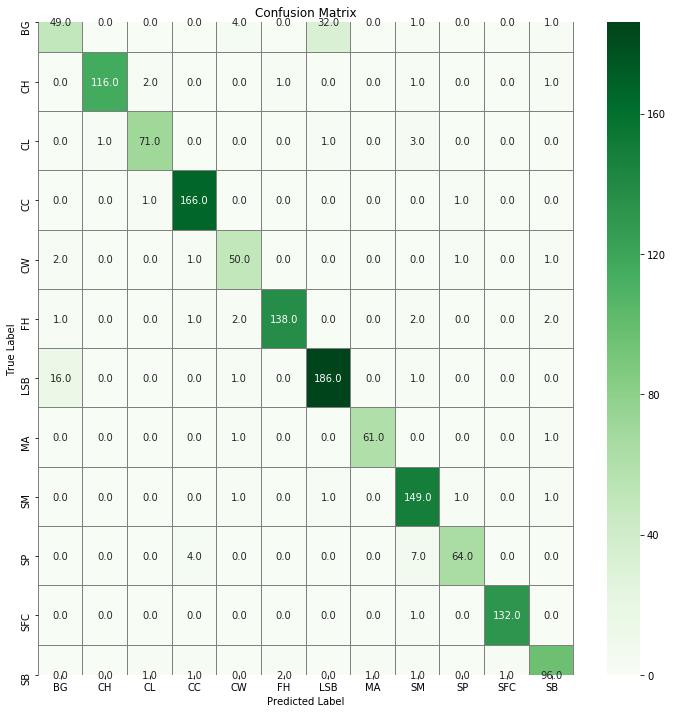

In [84]:
# plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 12))
ax = sns.heatmap(cnf_matrix, annot=True, linewidths=0.01, cmap="Greens", linecolor="gray", fmt= '.1f',ax=ax)
ax.set_xticklabels(ABBREVIATIONS)
ax.set_yticklabels(ABBREVIATIONS)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
fig.savefig('./fig/CNN2_confusion_matrix.png', dpi=300)

#### LeNet5 Model

In [ ]:
def LeNet5_model(input_shape=(28, 28, 1), nets=15):
    """
    LeNet5 based architecture with improvements:
    - Two stacked 3x3 filters replacing the single 5x5. These become nonlinear 5x5 convolutions
    - A convolution with stride 2 replaces pooling layers. These become learnable pooling layers.
    - ReLU activation replaces sigmoid.
    - Batch normalization, dropout and more features added.
    - An ensemble of 15 CNNs with bagging is used
    """
    model = [0] * nets
    for j in range(nets):
        model[j] = Sequential()
        # 
        model[j].add(Conv2D(32, kernel_size=3, activation='relu', input_shape=input_shape))
        model[j].add(BatchNormalization())
        model[j].add(Conv2D(32, kernel_size=3, activation='relu'))
        model[j].add(BatchNormalization())
        model[j].add(Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu'))
        model[j].add(BatchNormalization())
        model[j].add(Dropout(0.4))

        model[j].add(Conv2D(64, kernel_size=3, activation='relu'))
        model[j].add(BatchNormalization())
        model[j].add(Conv2D(64, kernel_size=3, activation='relu'))
        model[j].add(BatchNormalization())
        model[j].add(Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu'))
        model[j].add(BatchNormalization())
        model[j].add(Dropout(0.4))

        model[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
        model[j].add(BatchNormalization())
        model[j].add(Flatten())
        model[j].add(Dropout(0.4))
        model[j].add(Dense(10, activation='softmax'))

        # COMPILE: Adam Optimizer and Cross-Entropy Cost
        model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# LEARNING RATE: Decrease each epoch
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
# TRAIN all networks
history = [0] * nets
epochs = 45
for j in range(nets):
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(images_generated, labels_encoded, test_size=0.1)
    history[j] = model[j].fit_generator(datagen.flow(X_train2, Y_train2, batch_size=64),
        epochs = epochs, steps_per_epoch = X_train2.shape[0]//64,  
        validation_data = (X_val2, Y_val2), callbacks=[annealer], verbose=0)
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1, epochs, max(history[j].history['acc']), max(history[j].history['val_accuracy']) ))

In [ ]:
# ENSEMBLE Predictions and submit
results = np.zeros( (X_test.shape[0],10) ) 

for j in range(nets):
    Y_pred = Y_pred + model[j].predict(X_val)
Y_pred = np.argmax(Y_pred, axis = 1)
# results = pd.Series(Y_pred, name="Label")
# submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"), Y_pred],axis = 1)
# submission.to_csv("Plants-CNN-Ensemble.csv",index=False)

In [ ]:
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Greens", linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### Using a Pre-Trained Model

In [ ]:
pretrained_model = tf.keras.applications.MobileNet()